In [1]:
#disable warnings
import warnings
warnings.filterwarnings("ignore") 

In [2]:
#stuff

# Purpose of this Notebook

In [3]:
#Number of reviews to put into data frame of good reviews. Set it to less than 0 if you want all of the good reviews to be processed
NUMB_OF_DOCS1 = 1000

#Number of reviews to put into data frame of bad reviews
NUMB_OF_DOCS2=100

## Problem Statement

Product developers often want to know this about their products:

* For products that people don't like, what is it about the products they don't like? Maybe if we know this we could improve the product by fixing this unliked product features
* For products that people love, what is it about the products that result in people loving them? Maybe if we expanded on these loved features, we could get new customers or better retain current customers

## Proposed Solution

Topic modeling and clustering(?) that identifies the features of products that people love and somehow rank them so that a product manaer can have a priority list of things that could be addressed to get more love
Topic modeling and clustering(?) that identifies the features of products that people don't like and somehow rank them so that a product manaer can have a priority list of things that could be fixed to hopefully turn the disliked product into a liked product.


# Module Import

In [4]:



import datetime
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



import re

#to speed up pandas operands
from pandarallel import pandarallel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pyLDAvis
import pyLDAvis.sklearn

#gensim
from gensim import corpora, models, similarities, matutils



# NLP Pipeline



## Text Preprocessing
Essentially will do this:

```

(input text) -->[clean(remove text I don't want)]--> [tokenization] --> [lemmatization] --> [Next_Stages]

```

In [5]:
reviews_df = pd.read_csv("../Data/Reviews.csv")

In [6]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
reviews_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
reviews_df.loc[0,"Text"]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [9]:
reviews_df["Score"].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [10]:
reviews_df["helpful_rating"] = reviews_df["HelpfulnessNumerator"] / reviews_df["HelpfulnessDenominator"]

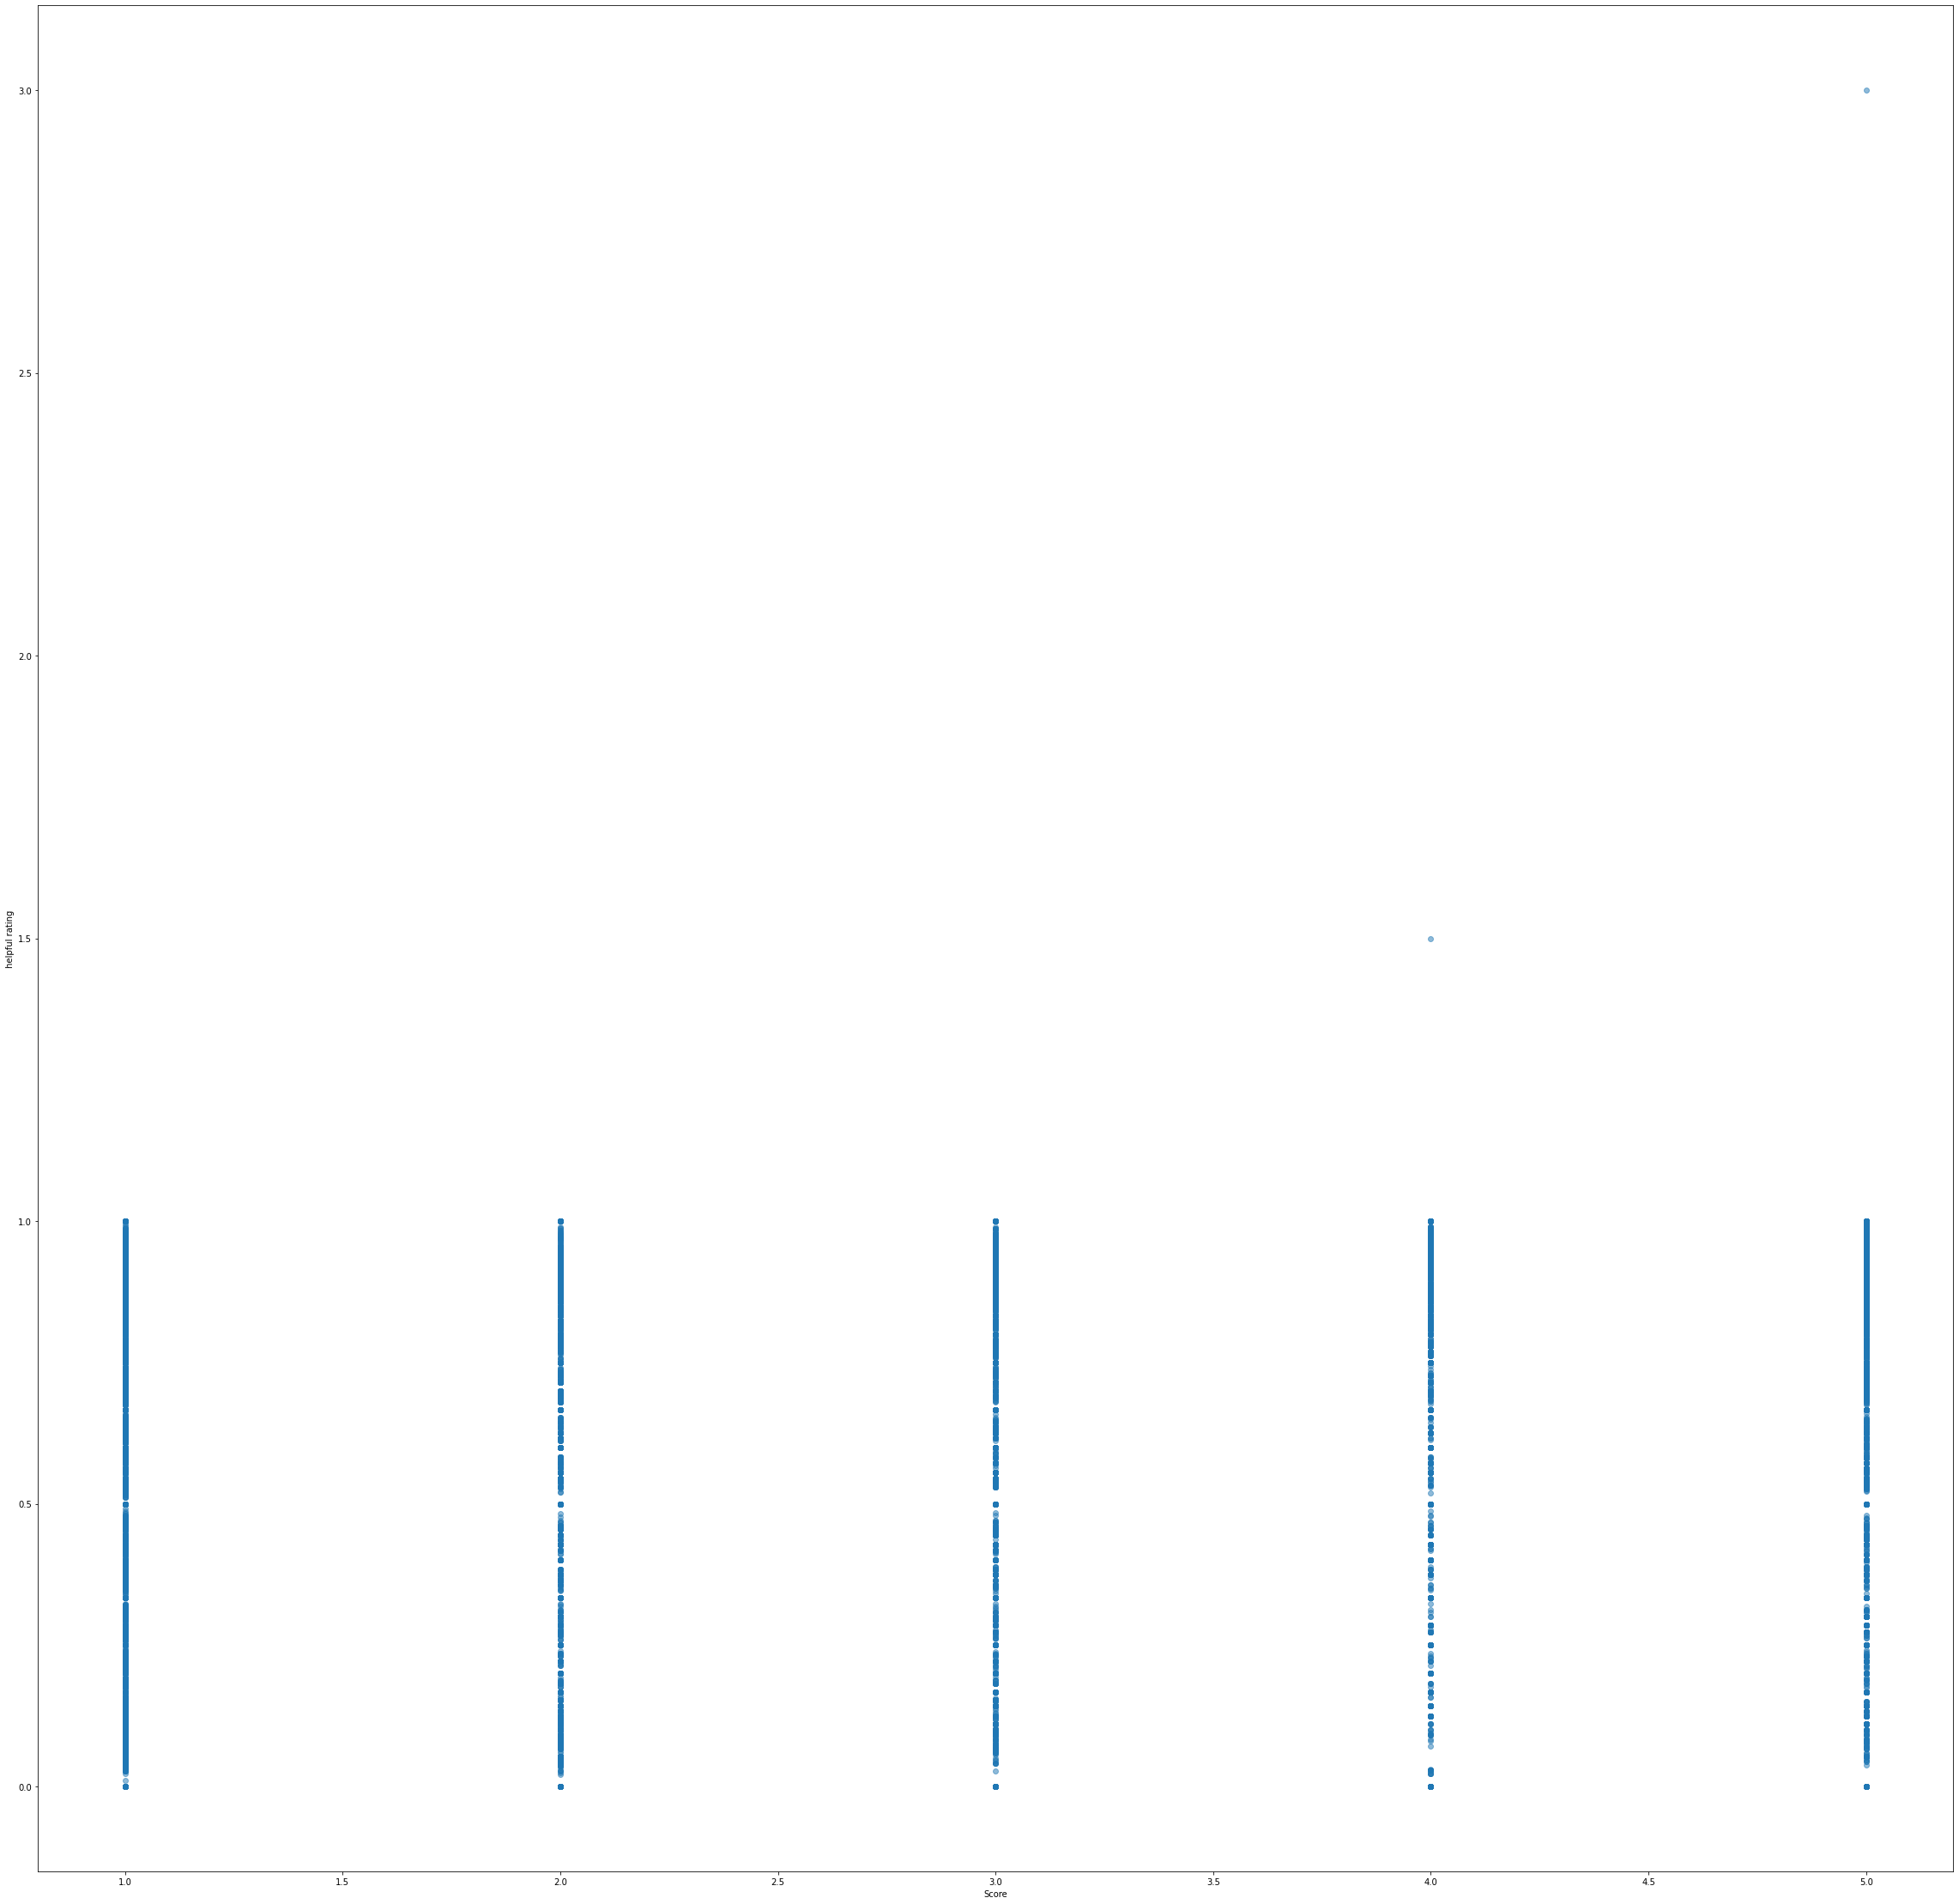

In [11]:
plt.figure(figsize=(40,40))
plt.scatter(reviews_df["Score"],reviews_df["helpful_rating"],alpha=0.5)
plt.xlabel("Score")
plt.ylabel("helpful rating")
plt.show();

Going to create a dataframe of bad reviews and one of good reviews to process separately

In [12]:
good_reviews_df = reviews_df[ reviews_df["Score"] >= 4 ]
bad_reviews_df = reviews_df[ reviews_df["Score"] <= 2 ]

In [13]:
if (NUMB_OF_DOCS1 > good_reviews_df.shape[0]) or (NUMB_OF_DOCS1 < 0):
    NUMB_OF_DOCS1 = good_reviews_df.shape[0]


if (NUMB_OF_DOCS2 > bad_reviews_df.shape[0]) or (NUMB_OF_DOCS2 < 0):
    NUMB_OF_DOCS2 = bad_reviews_df.shape[0]

In [14]:
stuff =list(good_reviews_df.Text.head(NUMB_OF_DOCS1))

In [15]:
#Removing HTML from the text
stuff = [re.sub("<.*?>","",item) for item in stuff]

In [16]:
#remove punctuation
stuff = [  re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-]","",mystring) for mystring in stuff  ]

**Tokenize**

In [ ]:
stuff_tokenized= []

stuff_tokenized = [word_tokenize(review) for review in stuff]

In [ ]:
#stuff_tokenized[1]

In [ ]:
#for i,item in enumerate(stuff_tokenized):
#    if i == 10:
#        break
#    print(i,"-->",item,"\n")

In [ ]:
#lemmatize each word in stuff
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos




In [ ]:
#for i,item in enumerate(stuff):
#   if i == 10:
#        break
#   print(i,"-->",item,"\n")

In [ ]:
stuff_tokenized[0]

lemmatizing to cut down on the size of the dimensions of the eventual vectorized word matrix without losing meaning of the text

In [ ]:
wordNetLemmatizer = WordNetLemmatizer()

stuff_lemmatized = []

for mydoc in stuff_tokenized:
    #temp_mydoc = " ".join(mydoc)
    temp_mydoc_lemmatized = []
    
    pos_result = pos_tag(mydoc)
    
    for myword,mypos in pos_result:

        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(mypos))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)

    stuff_lemmatized.append(temp_mydoc_lemmatized)
    
#stuff_lemmatized = [wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myword)) for mydoc in stuff_tokenized for myword in mydoc]



In [ ]:
#Test code doesn't need to be run
#myword = "running"
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myword))
#myword_lemmed = wordNetLemmatizer.lemmatize(myword,"v")

#print("myword_lemmed = ",myword_lemmed)
#print("POS for myword = ",calc_partofspeech(myword))

In [ ]:
#stuff_lemmatized[0]

In [ ]:
# I only want adjectives and adverbs sent to the vectorizer
#stuff_pos_filtered = [mylemword for mylemdoc in stuff_lemmatized for mylemword in mylemdoc if ("JJ" in pos_tag(word_tokenize(mylemword))[0][1]) or ("RB" in pos_tag(word_tokenize(mylemword))[0][1])]

In [ ]:
#stuff_pos_filtered[6]

In [ ]:
# I only want adjectives and adverbs sent to the vectorizer

def filter_pos(stuff_lemmatized,pos_abbrev=["JJ"]):
    """
    takes as input the following
    list_of_docs = a list(list(str)) object which is a list of documents that have been word tokenized and lemmatized
    pos_abbrev = list of NLTK pos_tag() output parts of speech codes abbreviated to the first two characters
    
    """
#    print("pos_abbrev = ",pos_abbrev)

    stuff_pos_filtered = []
    
    if type(pos_abbrev) != type([]):
        print("post_abbrev must be a list of POS codes (1st 2 char of the code only)")
        return 1

    for mylemdoc in stuff_lemmatized:
    
        temp_pos_filtered_doc = ""
        #pos_tag() works better if you pass the entire document to it as a tokenized list
        #it must be doing some sequence modeling under the hood to get context of words so that it can
        #better ID parts of speech
        
        pos_result = pos_tag(mylemdoc)
    
        for result_word, result_pos in pos_result:
#            print("tokenized word = ", word_tokenize(mylemword))
#            print("tokenized word pos = ", pos_tag(word_tokenize(mylemword))[0][1])
            for mypos in pos_abbrev:
                if (mypos in result_pos) :
                    temp_pos_filtered_doc = temp_pos_filtered_doc + result_word + " "
            
        stuff_pos_filtered.append(temp_pos_filtered_doc.rstrip())
    
    return stuff_pos_filtered


In [ ]:
stuff_pos_filtered = filter_pos(stuff_lemmatized,pos_abbrev=["JJ","RB"])
#stuff_pos_filtered
#stuff_pos_filtered = stuff_pos_filtered + filter_pos(stuff_lemmatized,"RB")

In [ ]:
stuff_pos_filtered[0:3]

In [ ]:
#stuff_lemmatized[0]

Get the nouns

In [ ]:
stuff_nouns = filter_pos(stuff_lemmatized,pos_abbrev=["NN"])

In [ ]:
stuff_nouns[0:3]

In [ ]:
stuff_pos_filtered[0:5]

In [ ]:
len(stuff_pos_filtered)

## Word Vectorization / Parsing

Will do the following here:

```

(lemmatized text)-->[WordVectorization(dropping stop word)] --> [POS tagging] --> [collect Adjectives]


```


In [ ]:
vectorizer = CountVectorizer(stop_words="english")
docTermMatrixCountVec = vectorizer.fit_transform(stuff_pos_filtered)

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
docTermMatrixCountVec.toarray()

In [ ]:
docTermMatrixCountVec.shape

In [ ]:

docTermMatrixCountVec_df = pd.DataFrame(docTermMatrixCountVec.toarray(), index=stuff_pos_filtered, columns=vectorizer.get_feature_names())

In [ ]:
docTermMatrixCountVec_df.head()

In [ ]:
LD_Allocator = LatentDirichletAllocation(n_components=5, random_state=0)
LD_Allocator.fit(docTermMatrixCountVec)

## Topics via LDA

## LDA on "Good" Reviews

In [ ]:
#pyLDAvis.enable_notebook()
#pyLDAvis.sklearn.prepare(LD_Allocator, docTermMatrixCountVec, vectorizer)